# CRF sequence tagging for Movie Queries

In [ ]:
Import any library that we use in this project

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
from nltk.tokenize import word_tokenize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata
import nltk

nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
Defining the function for extracting the dataset

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:                     
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt") 

In [4]:
# have a look at the first example
print(raw_training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [5]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

9775 instances
99491 words


In [6]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
       
    preprocessed_example = example
    return preprocessed_example

In [7]:
training_data = [preProcess(example) for example in raw_training_data]

In [8]:
# check the effect of pre-processing
print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [ ]:
Defining the function to do feature engineering by using NLP method

In [9]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [10]:
pip install python-crfsuite

You should consider upgrading via the 'C:\Users\ADMIN\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
Implement CRF Tagging to train the model

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

2443 instances
24686 words


In [13]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [14]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          B-ACTOR       0.76      0.88      0.81       812
      B-CHARACTER       0.72      0.26      0.38        90
       B-DIRECTOR       0.77      0.61      0.68       456
          B-GENRE       0.91      0.95      0.93      1117
           B-PLOT       0.60      0.40      0.48       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.87      0.82      0.84       451
         B-REVIEW       0.14      0.02      0.03        56
           B-SONG       0.69      0.17      0.27        54
          B-TITLE       0.58      0.50      0.54       562
        B-TRAILER       0.80      0.80      0.80        30
           B-YEAR       0.94      0.94      0.94       720
          I-ACTOR       0.75      0.89      0.81       862
      I-CHARACTER       0.76      0.29      0.42        75
       I-DIRECTOR       0.78      0.60      0.68       496
          I-GENRE       0.84      0.71      0.77       

In [15]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['B-RATINGS_AVERAGE', 'I-SONG', 'O', 'I-TITLE', 'B-TITLE', 'I-GENRE', 'B-YEAR', 'B-SONG', 'I-REVIEW', 'I-TRAILER', 'B-PLOT', 'I-RATING', 'B-DIRECTOR', 'B-TRAILER', 'I-PLOT', 'I-YEAR', 'I-CHARACTER', 'I-ACTOR', 'B-CHARACTER', 'B-ACTOR', 'I-RATINGS_AVERAGE', 'B-REVIEW', 'I-DIRECTOR', 'B-GENRE', 'B-RATING'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


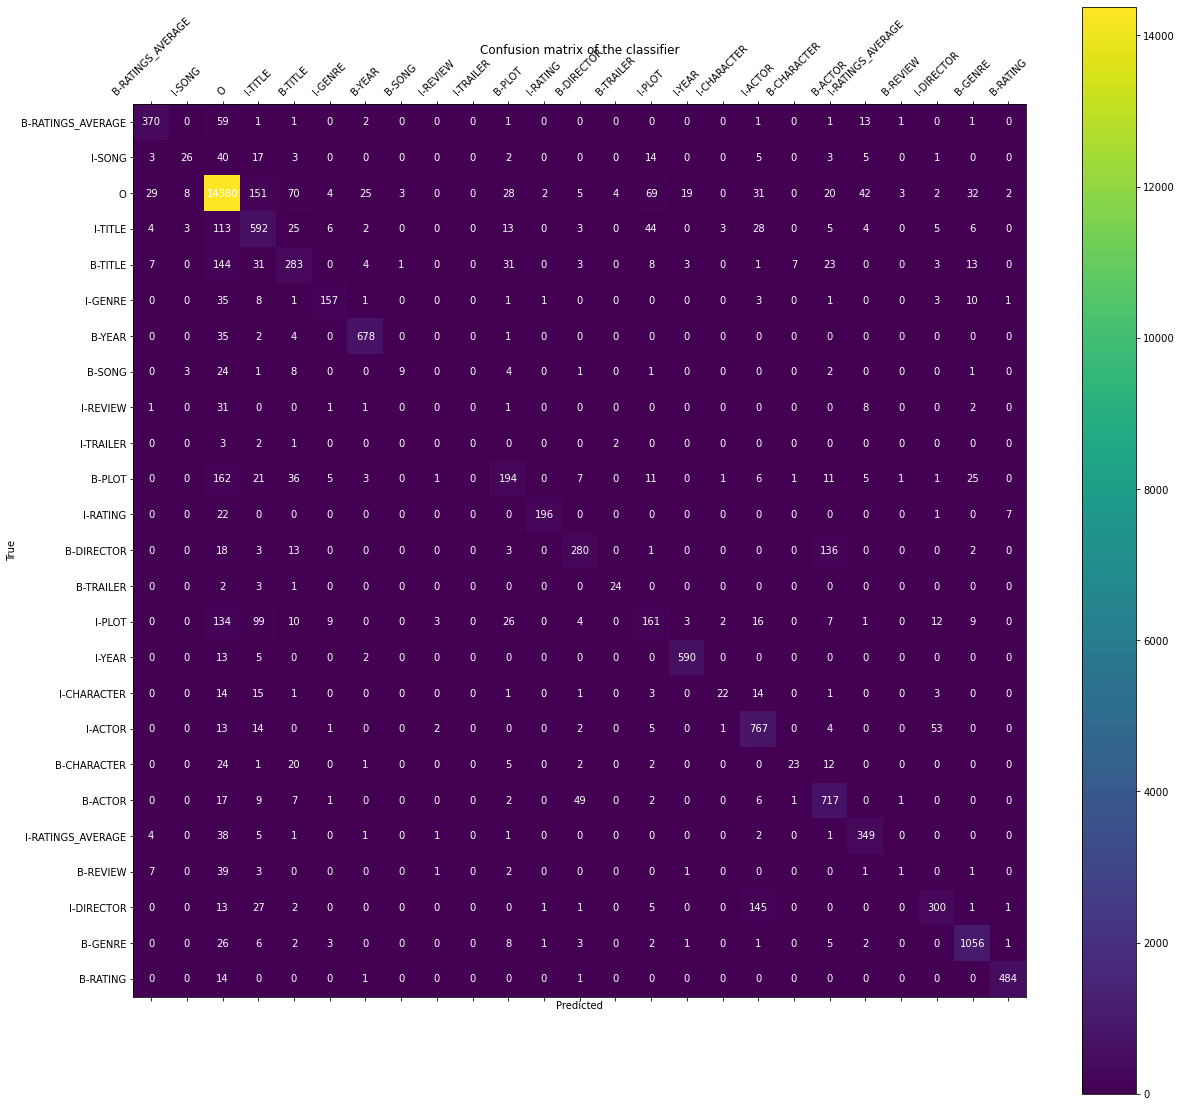

In [16]:
confusion_matrix_heatmap(y_test, preds)

# Split the training data into 80% training, 20% development set 
We need to separate the data from the engtrain.bio.txt- 80% for training data, 20% for developing the model 

In [20]:

percentage = 0.8 # separate the data in 80% of training data and 20% of testing_data
data_sample = len(training_data) # find the length of training_data
training_sample = int((percentage*data_sample)) # create the number of training data
train_dataset = training_data[:training_sample] # create the list which store train_data
test_dataset = training_data[training_sample:] # create the list which store test_data
    
  




# Error analysis 1: False positives 

we can perform error analysis for improving NLP application. So, we can illustrate 5 lowest precision classes, according to the result of 20% development data, showing the false positive for that class. For example,  the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word 

In [21]:
print("testing tagger...")
# we will train the data by using CRFTagger()
predict_result = [] #create list
y_predict = []
sent_predict_result = []
sent_y_predict = []  
for i in test_dataset:

      # we use the previous code the train the data
      sent_predict_result = [k[1] for k in ct.tag([j[0] for j in i])] # we will tag the word(j) by using ct.tag() and store BIO- tag in sent_predict_result
      sent_y_predict = [j[1] for j in i] # we store all BIO-tag, which has one line, in sent_y_predict
      predict_result.extend(sent_predict_result) # add the data in predict_result 
      y_predict.extend(sent_y_predict) # add the data in y_predict    


print("done")

testing tagger...
done


In [22]:
print(classification_report(y_predict,predict_result))

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.94      0.88       433
      B-CHARACTER       0.95      0.93      0.94        44
       B-DIRECTOR       0.90      0.81      0.86       365
          B-GENRE       0.97      0.98      0.98       927
           B-PLOT       0.80      0.61      0.69       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.90      0.91       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.76      0.65      0.70        20
          B-TITLE       0.85      0.66      0.74       679
        B-TRAILER       1.00      0.68      0.81        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.84      0.93      0.88       482
      I-CHARACTER       0.90      0.94      0.92        47
       I-DIRECTOR       0.91      0.81      0.86       410
          I-GENRE       0.95      1.00      0.97       

In [23]:
import pandas as pd 
def classification_report_table(table): # this function will convert classification_report to csv file
   data_table = []
   column_data = table.split('\n') # split the data and consider in single-line
   for i in column_data[2:-5]: # iterate the data which consider only the data (not white space). So we use index from 2 until the last five lines
       row_classification = {} # create dictionary
       row_data = ' '.join(i.split()) # split the data by all white space and join the data again by one white space
       row_data = row_data.split(' ') # split the data again in order to visualise easily, P.S. we use this method to distiguish the column
       row_classification['class'] = row_data[0] # given data in class
       row_classification['precision'] = ' '.join(map(str, row_data[1:2])) #given data in precision
       row_classification['recall'] = ' '.join(map(str, row_data[2:3])) #given data in recall
       row_classification['f1-score'] = ' '.join(map(str, row_data[3:4])) #given data in f1-score
       row_classification['support'] = row_data[-1] #given data in support
       data_table.append(row_classification) # add the all data in single line to data_table
   df = pd.DataFrame.from_dict(data_table) # use this data to create csv file
   df.to_csv('classification_report.csv' ,index = False)
   
x = classification_report(y_predict, predict_result) #store classification_report in x
classification_report_table(x) # execute function

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
y = pd.read_csv('classification_report.csv') # read classification_report.csv
print(y)

                class  precision  recall  f1-score  support
0             B-ACTOR       0.83    0.94      0.88      433
1         B-CHARACTER       0.95    0.93      0.94       44
2          B-DIRECTOR       0.90    0.81      0.86      365
3             B-GENRE       0.97    0.98      0.98      927
4              B-PLOT       0.80    0.61      0.69      298
5            B-RATING       1.00    1.00      1.00      430
6   B-RATINGS_AVERAGE       0.91    0.90      0.91      451
7            B-REVIEW       0.00    0.00      0.00       31
8              B-SONG       0.76    0.65      0.70       20
9             B-TITLE       0.85    0.66      0.74      679
10          B-TRAILER       1.00    0.68      0.81       28
11             B-YEAR       0.96    1.00      0.98      535
12            I-ACTOR       0.84    0.93      0.88      482
13        I-CHARACTER       0.90    0.94      0.92       47
14         I-DIRECTOR       0.91    0.81      0.86      410
15            I-GENRE       0.95    1.00

In [26]:
y_precision = y.sort_values(by = ['precision']) # sort value by 'precision' from lowest to highest
y_precision[0:5] # visualise the five lowest precision to illustrate 5 cases in false postive


,class,precision,recall,f1-score,support
22,I-TRAILER,0.00,0.00,0.00,1
19,I-REVIEW,0.00,0.00,0.00,9
7,B-REVIEW,0.00,0.00,0.00,31
16,I-PLOT,0.63,0.81,0.71,148
20,I-SONG,0.68,0.63,0.65,43


# Error analysis 2: False negatives 

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). 

Also, we should examine the 5 lowest recall of the classes, according to the 20% development data, finding the false negative for that label. For example,the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger  


In [27]:
y_recall = y.sort_values(by = ['recall']) #sort value by 'recall' from lowest to highest
y_recall[0:5] #visualise the five lowest precision to illustrate 5 cases in false postive

,class,precision,recall,f1-score,support
22,I-TRAILER,0.00,0.00,0.00,1
7,B-REVIEW,0.00,0.00,0.00,31
19,I-REVIEW,0.00,0.00,0.00,9
4,B-PLOT,0.80,0.61,0.69,298
20,I-SONG,0.68,0.63,0.65,43
